Hybrid LSTM-CNN

accuracy: 60%

Loading and preprocessing labels for 9-class classification...
Aggregating multi-annotator labels...
Successfully processed and labeled 400 unique tracks.
Class distribution in the dataset (9 classes):
dominant_emotion
calmness             98
joyful_activation    93
nostalgia            53
tension              44
power                34
solemnity            29
tenderness           27
sadness              19
amazement             3
Name: count, dtype: int64

Extracting features from audio files... (This may take a while)


Processing Audio:  57%|█████▋    | 227/400 [01:44<01:22,  2.09it/s]c:\Users\Elite\anaconda3\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Processing Audio: 100%|██████████| 400/400 [03:00<00:00,  2.21it/s]


Encoding labels and splitting data...
Applying SMOTE to balance training data...
Scaling features...

Building and training the CNN-LSTM model...
Model will be trained to classify 9 emotions.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 52, 256)        │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 26, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 26, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 26, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,033 (847.79 KB)

 Trainable params: 216,265 (844.79 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/150
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2083 - loss: 2.0926 - val_accuracy: 0.0024 - val_loss: 2.4357 - learning_rate: 1.0000e-04
Epoch 2/150
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3241 - loss: 1.8880 - val_accuracy: 0.0061 - val_loss: 2.4314 - learning_rate: 1.0000e-04
Epoch 3/150
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3871 - loss: 1.7531 - val_accuracy: 0.0373 - val_loss: 2.7737 - learning_rate: 1.0000e-04
Epoch 4/150
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4259 - loss: 1.6542 - val_accuracy: 0.0595 - val_loss: 2.9284 - learning_rate: 1.0000e-04
Epoch 5/150
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4649 - loss: 1.5445 - val_accuracy: 0.0605 - val_loss: 2.6060 - learning_rate: 1.0000e-04
Epoch 6/150
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4910 - loss: 1.4551 - val_accuracy: 0.0704 - val_loss: 2.7621 - learning_rate: 1.0000e-04
Epoch 7/150
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - ac

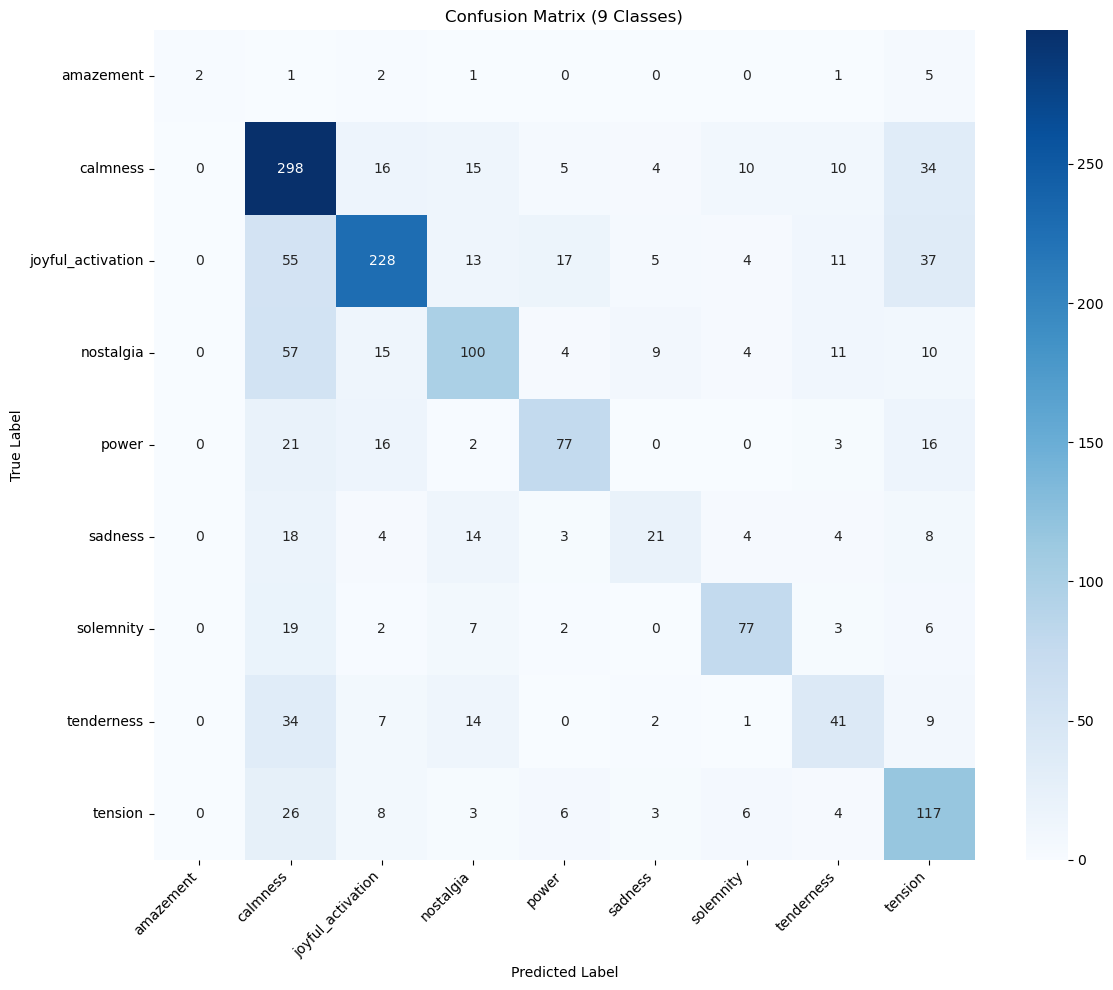

In [3]:
import pandas as pd
import numpy as np
import librosa
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D,
    BatchNormalization,
    MaxPooling1D,
    Dropout,
    LSTM,
    Dense,
    Input,
)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tqdm import tqdm

# --- Configuration ---
# NOTE: Update these paths to point to your local dataset location
ANNOTATIONS_PATH = "./data.csv"
AUDIO_DIR = "./audio"  # Assuming MP3s are in the same directory as the script
SEGMENT_DURATION = 3  # seconds

def load_and_prepare_labels(annotations_path):
    """
    Loads annotations from data.csv and determines the single most dominant
    emotion for each track from the 9 available emotion columns.
    """
    print("Loading and preprocessing labels for 9-class classification...")
    try:
        df = pd.read_csv(annotations_path)
    except FileNotFoundError:
        print(f"Error: The file was not found at {annotations_path}")
        return None

    # Define the 9 raw emotion columns directly from your CSV
    # The leading space is important to match the column names
    emotion_cols = [
        ' amazement', ' solemnity', ' tenderness', ' nostalgia', 
        ' calmness', ' power', ' joyful_activation', ' tension', ' sadness'
    ]

    # Step 1: Group by track and calculate the mean for each emotion column.
    # This represents the consensus score from annotators for each emotion.
    print("Aggregating multi-annotator labels...")
    song_emotion_scores = df.groupby('track id')[emotion_cols].mean()

    # Step 2: Determine the dominant emotion for each song.
    # The dominant emotion is the one with the highest mean score.
    # The .idxmax(axis=1) function finds the column name with the maximum value for each row.
    song_emotion_scores['dominant_emotion'] = song_emotion_scores[emotion_cols].idxmax(axis=1)
    
    # Strip leading spaces from the dominant_emotion column for cleaner labels
    song_emotion_scores['dominant_emotion'] = song_emotion_scores['dominant_emotion'].str.strip()

    # Create the final DataFrame with the track ID and its single dominant emotion
    final_df = song_emotion_scores.reset_index()[['track id', 'dominant_emotion']]
    
    print(f"Successfully processed and labeled {len(final_df)} unique tracks.")
    print("Class distribution in the dataset (9 classes):")
    print(final_df['dominant_emotion'].value_counts())
    
    return final_df


def extract_features_from_audio(file_path, duration=3):
    """
    Extracts a comprehensive set of audio features from 3-second segments of an
    audio file.
    """
    try:
        audio, sr = librosa.load(file_path, sr=22050, duration=60)
        features_list = []
        
        samples_per_segment = int(duration * sr)

        for start in range(0, len(audio) - samples_per_segment + 1, samples_per_segment):
            segment = audio[start:start + samples_per_segment]
            
            # Extract features
            chroma_stft = librosa.feature.chroma_stft(y=segment, sr=sr)
            rms = librosa.feature.rms(y=segment)
            spec_cent = librosa.feature.spectral_centroid(y=segment, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=segment, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=segment, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(segment)
            mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=20)

            # Aggregate features
            features = np.hstack([
                np.mean(chroma_stft), np.std(chroma_stft),
                np.mean(rms), np.std(rms),
                np.mean(spec_cent), np.std(spec_cent),
                np.mean(spec_bw), np.std(spec_bw),
                np.mean(rolloff), np.std(rolloff),
                np.mean(zcr), np.std(zcr)
            ])
            
            mfcc_features = np.hstack([np.mean(e) for e in mfcc] + [np.std(e) for e in mfcc])
            features = np.hstack([features, mfcc_features])
            features_list.append(features)
            
        return features_list
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return []

def build_cnn_lstm_model(input_shape, num_classes):
    """
    Builds the hybrid CNN-LSTM model. This architecture is flexible and will
    adapt to the number of classes provided.
    """
    model = Sequential()
    
    model.add(Input(shape=input_shape))
    
    # CNN Blocks
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
    
    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

    # Dropout and LSTM
    model.add(Dropout(0.3))
    model.add(LSTM(64))
    
    # Output Layer: Automatically adjusts to num_classes (which will be 9)
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# --- Main Execution ---
if __name__ == '__main__':
    # 1. Load Labels (now for 9 classes)
    labeled_data = load_and_prepare_labels(ANNOTATIONS_PATH)
    
    if labeled_data is None:
        exit()

    # 2. Extract Features (this process is unchanged)
    print("\nExtracting features from audio files... (This may take a while)")
    all_features = []
    all_labels = []
    for _, row in tqdm(labeled_data.iterrows(), total=len(labeled_data), desc="Processing Audio"):
        audio_path = os.path.join(AUDIO_DIR, f"{row['track id']}.mp3")
        
        if os.path.exists(audio_path):
            features = extract_features_from_audio(audio_path, duration=SEGMENT_DURATION)
            if features:
                all_features.extend(features)
                all_labels.extend([row['dominant_emotion']] * len(features))
    
    if not all_features:
        print("\nError: No features were extracted. Check your AUDIO_DIR.")
        exit()

    X = np.array(all_features)
    y_str = np.array(all_labels)

    # 3. Encode Labels & Split Data
    print("\nEncoding labels and splitting data...")
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y_str)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # 4. Apply SMOTE to balance the 9-class training data
    print("Applying SMOTE to balance training data...")
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # 5. Scale Features
    print("Scaling features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)
    
    # 6. Reshape data for Conv1D layer
    X_train_reshaped = np.expand_dims(X_train_scaled, axis=2)
    X_test_reshaped = np.expand_dims(X_test_scaled, axis=2)

    # 7. Build and Train the Model for 9 classes
    print("\nBuilding and training the CNN-LSTM model...")
    num_classes = len(label_encoder.classes_)
    print(f"Model will be trained to classify {num_classes} emotions.")
    model = build_cnn_lstm_model(X_train_reshaped.shape[1:], num_classes)
    model.summary()
    
    # Callbacks for robust training
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

    history = model.fit(
        X_train_reshaped,
        y_train_resampled,
        validation_split=0.15,
        epochs=150,
        batch_size=64,
        callbacks=[reduce_lr, early_stop]
    )

    # 8. Evaluate the Model
    print("\nEvaluating model on the test set...")
    test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # 9. Generate Classification Report and Confusion Matrix for 9 classes
    y_pred_probs = model.predict(X_test_reshaped)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix (9 Classes)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


Hybrid LSTM-CNN with advanced feature selection

accuracy: 58%

Loading and preprocessing labels for 9-class classification...
Aggregating multi-annotator labels...
Successfully processed and labeled 400 unique tracks.
Class distribution in the dataset (9 classes):
dominant_emotion
calmness             98
joyful_activation    93
nostalgia            53
tension              44
power                34
solemnity            29
tenderness           27
sadness              19
amazement             3
Name: count, dtype: int64

Extracting ADVANCED features from audio files... (This may take longer)


Processing Audio:  57%|█████▋    | 227/400 [13:31<08:11,  2.84s/it]c:\Users\Elite\anaconda3\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Processing Audio: 100%|██████████| 400/400 [21:39<00:00,  3.25s/it]


Encoding labels and splitting data...
Applying SMOTE to balance training data...
Scaling features...

Building and training the CNN-LSTM model...
Model will be trained to classify 9 emotions using an enhanced feature set.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 78, 256)        │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 78, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 39, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 39, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 39, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,033 (847.79 KB)

 Trainable params: 216,265 (844.79 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/150
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2689 - loss: 1.9884 - val_accuracy: 0.0000e+00 - val_loss: 2.6712 - learning_rate: 1.0000e-04
Epoch 2/150
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4090 - loss: 1.6844 - val_accuracy: 0.0142 - val_loss: 2.8671 - learning_rate: 1.0000e-04
Epoch 3/150
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4630 - loss: 1.5495 - val_accuracy: 0.0548 - val_loss: 2.6784 - learning_rate: 1.0000e-04
Epoch 4/150
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4877 - loss: 1.4646 - val_accuracy: 0.0420 - val_loss: 2.8375 - learning_rate: 1.0000e-04
Epoch 5/150
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5085 - loss: 1.4016 - val_accuracy: 0.1205 - val_loss: 2.5989 - learning_rate: 1.0000e-04
Epoch 6/150
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5482 - loss: 1.3229 - val_accuracy: 0.1034 - val_loss: 2.6624 - learning_rate: 1.0000e-04
Epoch 7/150
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms

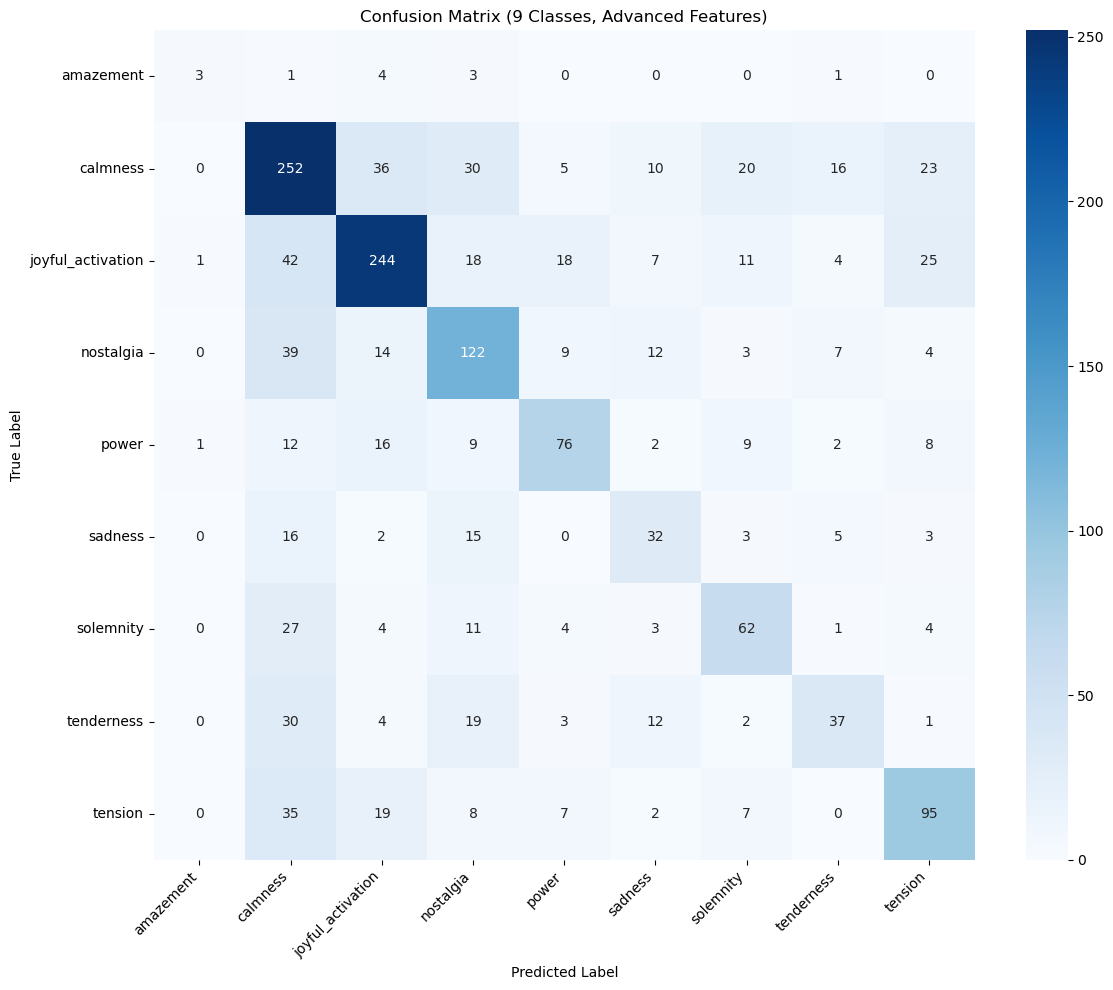

In [4]:
import pandas as pd
import numpy as np
import librosa
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D,
    BatchNormalization,
    MaxPooling1D,
    Dropout,
    LSTM,
    Dense,
    Input,
)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tqdm import tqdm

# --- Configuration ---
ANNOTATIONS_PATH = "./data.csv"
AUDIO_DIR = "./audio" 
SEGMENT_DURATION = 3  # seconds

def load_and_prepare_labels(annotations_path):
    """
    Loads annotations from data.csv and determines the single most dominant
    emotion for each track from the 9 available emotion columns.
    """
    print("Loading and preprocessing labels for 9-class classification...")
    try:
        df = pd.read_csv(annotations_path)
    except FileNotFoundError:
        print(f"Error: The file was not found at {annotations_path}")
        return None

    emotion_cols = [
        ' amazement', ' solemnity', ' tenderness', ' nostalgia', 
        ' calmness', ' power', ' joyful_activation', ' tension', ' sadness'
    ]

    print("Aggregating multi-annotator labels...")
    song_emotion_scores = df.groupby('track id')[emotion_cols].mean()
    song_emotion_scores['dominant_emotion'] = song_emotion_scores[emotion_cols].idxmax(axis=1)
    song_emotion_scores['dominant_emotion'] = song_emotion_scores['dominant_emotion'].str.strip()

    final_df = song_emotion_scores.reset_index()[['track id', 'dominant_emotion']]
    
    print(f"Successfully processed and labeled {len(final_df)} unique tracks.")
    print("Class distribution in the dataset (9 classes):")
    print(final_df['dominant_emotion'].value_counts())
    
    return final_df


def extract_features_from_audio(file_path, duration=3):
    """
    Extracts an ADVANCED set of audio features from 3-second segments.
    Includes standard features plus Spectral Contrast and Tonnetz for more
    detailed timbral and harmonic information.
    """
    try:
        audio, sr = librosa.load(file_path, sr=22050, duration=60)
        features_list = []
        
        samples_per_segment = int(duration * sr)

        for start in range(0, len(audio) - samples_per_segment + 1, samples_per_segment):
            segment = audio[start:start + samples_per_segment]
            
            # --- Standard Features ---
            chroma_stft = librosa.feature.chroma_stft(y=segment, sr=sr)
            rms = librosa.feature.rms(y=segment)
            spec_cent = librosa.feature.spectral_centroid(y=segment, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=segment, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=segment, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(segment)
            mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=20)
            
            # --- Advanced Features ---
            # Spectral Contrast: Captures the strength of spectral peaks and valleys.
            # Useful for textural and timbral differences.
            spec_contrast = librosa.feature.spectral_contrast(y=segment, sr=sr)
            
            # Tonnetz (Tonal Centroid Features): Represents the harmonic content.
            # Very effective for capturing musical mood.
            tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(segment), sr=sr)
            
            # --- Aggregate all features ---
            base_features = np.hstack([
                np.mean(chroma_stft), np.std(chroma_stft),
                np.mean(rms), np.std(rms),
                np.mean(spec_cent), np.std(spec_cent),
                np.mean(spec_bw), np.std(spec_bw),
                np.mean(rolloff), np.std(rolloff),
                np.mean(zcr), np.std(zcr)
            ])
            
            # For multi-dimensional features, get mean and std for each coefficient
            mfcc_features = np.hstack([np.mean(e) for e in mfcc] + [np.std(e) for e in mfcc])
            spec_contrast_features = np.hstack([np.mean(e) for e in spec_contrast] + [np.std(e) for e in spec_contrast])
            tonnetz_features = np.hstack([np.mean(e) for e in tonnetz] + [np.std(e) for e in tonnetz])

            # Combine into a single feature vector for the segment
            all_segment_features = np.hstack([base_features, mfcc_features, spec_contrast_features, tonnetz_features])
            features_list.append(all_segment_features)
            
        return features_list
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return []

def build_cnn_lstm_model(input_shape, num_classes):
    """
    Builds the hybrid CNN-LSTM model. The increased number of features from
    feature extraction will be handled by the input layer.
    """
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
    model.add(Dropout(0.3))
    model.add(LSTM(64))
    model.add(Dense(num_classes, activation='softmax'))
    
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# --- Main Execution ---
if __name__ == '__main__':
    labeled_data = load_and_prepare_labels(ANNOTATIONS_PATH)
    if labeled_data is None:
        exit()

    print("\nExtracting ADVANCED features from audio files... (This may take longer)")
    all_features = []
    all_labels = []
    for _, row in tqdm(labeled_data.iterrows(), total=len(labeled_data), desc="Processing Audio"):
        audio_path = os.path.join(AUDIO_DIR, f"{row['track id']}.mp3")
        if os.path.exists(audio_path):
            features = extract_features_from_audio(audio_path, duration=SEGMENT_DURATION)
            if features:
                all_features.extend(features)
                all_labels.extend([row['dominant_emotion']] * len(features))
    
    if not all_features:
        print("\nError: No features were extracted. Check your AUDIO_DIR.")
        exit()

    X = np.array(all_features)
    y_str = np.array(all_labels)

    print("\nEncoding labels and splitting data...")
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y_str)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    print("Applying SMOTE to balance training data...")
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    print("Scaling features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_reshaped = np.expand_dims(X_train_scaled, axis=2)
    X_test_reshaped = np.expand_dims(X_test_scaled, axis=2)

    print("\nBuilding and training the CNN-LSTM model...")
    num_classes = len(label_encoder.classes_)
    print(f"Model will be trained to classify {num_classes} emotions using an enhanced feature set.")
    model = build_cnn_lstm_model(X_train_reshaped.shape[1:], num_classes)
    model.summary()
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

    history = model.fit(
        X_train_reshaped,
        y_train_resampled,
        validation_split=0.15,
        epochs=150,
        batch_size=64,
        callbacks=[reduce_lr, early_stop]
    )

    print("\nEvaluating model on the test set...")
    test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    y_pred_probs = model.predict(X_test_reshaped)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix (9 Classes, Advanced Features)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

Hybrid using BiDirectional LSTM-CNN

accuracy: 67%

Loading and preprocessing labels for 9-class classification...
Aggregating multi-annotator labels...
Successfully processed and labeled 400 unique tracks.
Class distribution in the dataset (9 classes):
dominant_emotion
calmness             98
joyful_activation    93
nostalgia            53
tension              44
power                34
solemnity            29
tenderness           27
sadness              19
amazement             3
Name: count, dtype: int64

Extracting ADVANCED features from audio files...


Processing Audio:  57%|█████▋    | 227/400 [13:18<15:25,  5.35s/it]c:\Users\Elite\anaconda3\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Processing Audio: 100%|██████████| 400/400 [23:17<00:00,  3.49s/it]


Encoding labels and splitting data...
Applying SMOTE to balance training data...
Scaling features...

Building and training the Bidirectional CNN-LSTM model...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 78, 256)        │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 78, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 39, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 39, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 39, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,017 (1.02 MB)

 Trainable params: 266,249 (1.02 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/150
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.2976 - loss: 1.9473 - val_accuracy: 4.7237e-04 - val_loss: 2.6195 - learning_rate: 1.0000e-04
Epoch 2/150
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4479 - loss: 1.6080 - val_accuracy: 0.0090 - val_loss: 2.7391 - learning_rate: 1.0000e-04
Epoch 3/150
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5240 - loss: 1.4357 - val_accuracy: 0.0557 - val_loss: 2.5859 - learning_rate: 1.0000e-04
Epoch 4/150
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5546 - loss: 1.3270 - val_accuracy: 0.0789 - val_loss: 2.7614 - learning_rate: 1.0000e-04
Epoch 5/150
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5884 - loss: 1.2227 - val_accuracy: 0.1389 - val_loss: 2.3899 - learning_rate: 1.0000e-04
Epoch 6/150
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6173 - loss: 1.1409 - val_accuracy: 0.0959 - val_loss: 2.5742 - learning_rate: 1.0000e-04
Epoch 7/150
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms

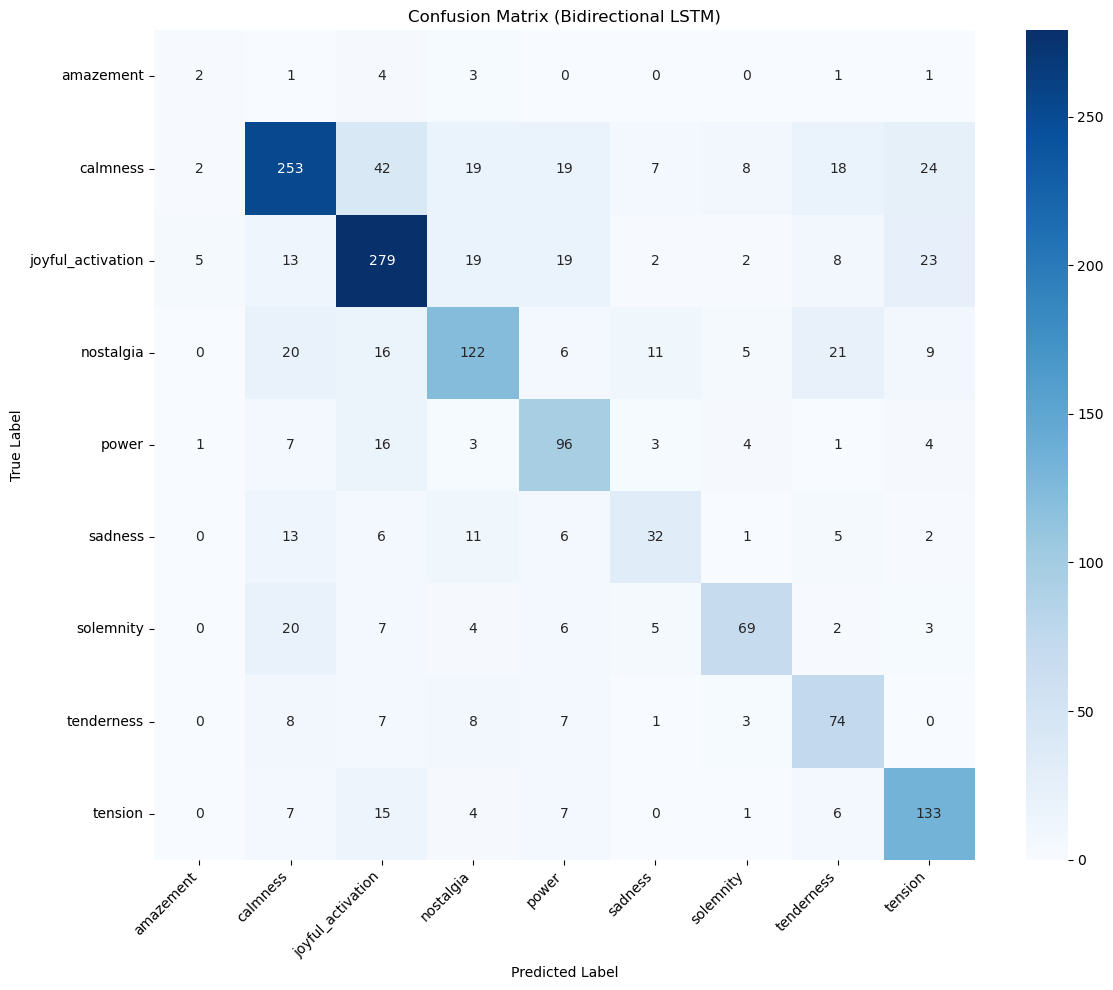

In [5]:
import pandas as pd
import numpy as np
import librosa
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D,
    BatchNormalization,
    MaxPooling1D,
    Dropout,
    LSTM,
    Dense,
    Input,
    Bidirectional # Import the Bidirectional layer
)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tqdm import tqdm

# --- Configuration ---
ANNOTATIONS_PATH = "./data.csv"
AUDIO_DIR = "./audio" 
SEGMENT_DURATION = 3  # seconds

def load_and_prepare_labels(annotations_path):
    """
    Loads annotations from data.csv and determines the single most dominant
    emotion for each track from the 9 available emotion columns.
    """
    print("Loading and preprocessing labels for 9-class classification...")
    try:
        df = pd.read_csv(annotations_path)
    except FileNotFoundError:
        print(f"Error: The file was not found at {annotations_path}")
        return None

    emotion_cols = [
        ' amazement', ' solemnity', ' tenderness', ' nostalgia', 
        ' calmness', ' power', ' joyful_activation', ' tension', ' sadness'
    ]

    print("Aggregating multi-annotator labels...")
    song_emotion_scores = df.groupby('track id')[emotion_cols].mean()
    song_emotion_scores['dominant_emotion'] = song_emotion_scores[emotion_cols].idxmax(axis=1)
    song_emotion_scores['dominant_emotion'] = song_emotion_scores['dominant_emotion'].str.strip()

    final_df = song_emotion_scores.reset_index()[['track id', 'dominant_emotion']]
    
    print(f"Successfully processed and labeled {len(final_df)} unique tracks.")
    print("Class distribution in the dataset (9 classes):")
    print(final_df['dominant_emotion'].value_counts())
    
    return final_df


def extract_features_from_audio(file_path, duration=3):
    """
    Extracts an ADVANCED set of audio features from 3-second segments.
    """
    try:
        audio, sr = librosa.load(file_path, sr=22050, duration=60)
        features_list = []
        
        samples_per_segment = int(duration * sr)

        for start in range(0, len(audio) - samples_per_segment + 1, samples_per_segment):
            segment = audio[start:start + samples_per_segment]
            
            # --- Standard & Advanced Features ---
            chroma_stft = librosa.feature.chroma_stft(y=segment, sr=sr)
            rms = librosa.feature.rms(y=segment)
            spec_cent = librosa.feature.spectral_centroid(y=segment, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=segment, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=segment, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(segment)
            mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=20)
            spec_contrast = librosa.feature.spectral_contrast(y=segment, sr=sr)
            tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(segment), sr=sr)
            
            # --- Aggregate all features ---
            base_features = np.hstack([
                np.mean(chroma_stft), np.std(chroma_stft),
                np.mean(rms), np.std(rms),
                np.mean(spec_cent), np.std(spec_cent),
                np.mean(spec_bw), np.std(spec_bw),
                np.mean(rolloff), np.std(rolloff),
                np.mean(zcr), np.std(zcr)
            ])
            
            mfcc_features = np.hstack([np.mean(e) for e in mfcc] + [np.std(e) for e in mfcc])
            spec_contrast_features = np.hstack([np.mean(e) for e in spec_contrast] + [np.std(e) for e in spec_contrast])
            tonnetz_features = np.hstack([np.mean(e) for e in tonnetz] + [np.std(e) for e in tonnetz])

            all_segment_features = np.hstack([base_features, mfcc_features, spec_contrast_features, tonnetz_features])
            features_list.append(all_segment_features)
            
        return features_list
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return []

def build_cnn_lstm_model(input_shape, num_classes):
    """
    Builds the hybrid CNN-LSTM model, now using a Bidirectional LSTM
    to capture temporal patterns from both forward and backward directions.
    """
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    # CNN Blocks for feature extraction from the sequence
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
    
    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
    
    model.add(Dropout(0.3))
    
    # *** MODEL CHANGE HERE ***
    # Using a Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(64)))
    
    # Final classification layer
    model.add(Dense(num_classes, activation='softmax'))
    
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# --- Main Execution ---
if __name__ == '__main__':
    labeled_data = load_and_prepare_labels(ANNOTATIONS_PATH)
    if labeled_data is None:
        exit()

    print("\nExtracting ADVANCED features from audio files...")
    all_features = []
    all_labels = []
    for _, row in tqdm(labeled_data.iterrows(), total=len(labeled_data), desc="Processing Audio"):
        audio_path = os.path.join(AUDIO_DIR, f"{row['track id']}.mp3")
        if os.path.exists(audio_path):
            features = extract_features_from_audio(audio_path, duration=SEGMENT_DURATION)
            if features:
                all_features.extend(features)
                all_labels.extend([row['dominant_emotion']] * len(features))
    
    if not all_features:
        print("\nError: No features were extracted. Check your AUDIO_DIR.")
        exit()

    X = np.array(all_features)
    y_str = np.array(all_labels)

    print("\nEncoding labels and splitting data...")
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y_str)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    print("Applying SMOTE to balance training data...")
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    print("Scaling features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_reshaped = np.expand_dims(X_train_scaled, axis=2)
    X_test_reshaped = np.expand_dims(X_test_scaled, axis=2)

    print("\nBuilding and training the Bidirectional CNN-LSTM model...")
    num_classes = len(label_encoder.classes_)
    model = build_cnn_lstm_model(X_train_reshaped.shape[1:], num_classes)
    model.summary()
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

    history = model.fit(
        X_train_reshaped,
        y_train_resampled,
        validation_split=0.15,
        epochs=150,
        batch_size=64,
        callbacks=[reduce_lr, early_stop]
    )

    print("\nEvaluating model on the test set...")
    test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    y_pred_probs = model.predict(X_test_reshaped)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix (Bidirectional LSTM)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


2D Convolution Netowrk CNN

accuracy: 64%

Loading and preprocessing labels...
Class distribution:
 dominant_emotion
calmness             98
joyful_activation    93
nostalgia            53
tension              44
power                34
solemnity            29
tenderness           27
sadness              19
amazement             3
Name: count, dtype: int64

Extracting Spectrograms... (This may take a while)


Processing Audio: 100%|██████████| 400/400 [00:50<00:00,  7.96it/s]



Encoding labels and splitting data...

Building and training the 2D CNN model...


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 63, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 30, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,518,665 (24.87 MB)

 Trainable params: 6,518,217 (24.87 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - accuracy: 0.2908 - loss: 2.2815 - val_accuracy: 0.3687 - val_loss: 1.7223 - learning_rate: 1.0000e-04
Epoch 2/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - accuracy: 0.4620 - loss: 1.5130 - val_accuracy: 0.5377 - val_loss: 1.3645 - learning_rate: 1.0000e-04
Epoch 3/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.6561 - loss: 1.0122 - val_accuracy: 0.5609 - val_loss: 1.2809 - learning_rate: 1.0000e-04
Epoch 4/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.7789 - loss: 0.6650 - val_accuracy: 0.6212 - val_loss: 1.1091 - learning_rate: 1.0000e-04
Epoch 5/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - accuracy: 0.8865 - loss: 0.3814 - val_accuracy: 0.6363 - val_loss: 1.0601 - learning_rate: 1.0000e-04
Epoch 6/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step - accuracy: 0.9247 - loss: 0.2422 - val_accuracy: 0.6501 - val_loss: 1.0910 - learning_rate: 1.0000e-04
Epoch 7/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 15s 7

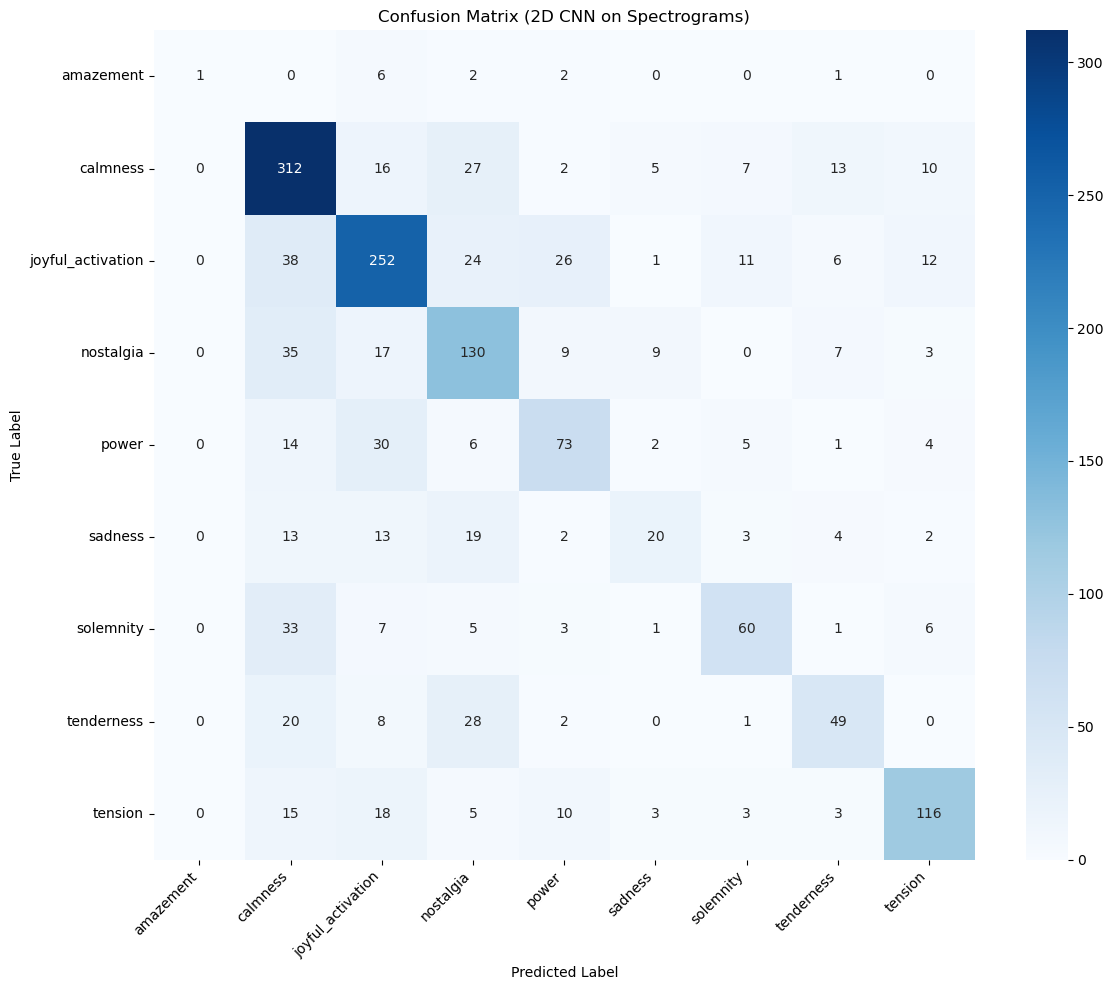

In [6]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Dropout,
    Dense,
    Input,
    Flatten,
    BatchNormalization
)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tqdm import tqdm

# --- Configuration ---
ANNOTATIONS_PATH = "./data.csv"
AUDIO_DIR = "./audio" 
SEGMENT_DURATION = 3  # seconds

# --- Feature Extraction (Now generates Spectrograms) ---
def extract_spectrogram(file_path, duration=3):
    """
    Extracts a Mel Spectrogram from a 3-second segment of an audio file.
    The spectrogram is treated as an image for the 2D CNN.
    """
    try:
        audio, sr = librosa.load(file_path, sr=22050, duration=60)
        spectrograms = []
        
        samples_per_segment = int(duration * sr)

        for start in range(0, len(audio) - samples_per_segment + 1, samples_per_segment):
            segment = audio[start:start + samples_per_segment]
            
            # Generate Mel Spectrogram
            # n_mels=128 means we get 128 frequency bands.
            # fmax=8000 caps the frequency range, common for music.
            mel_spect = librosa.feature.melspectrogram(y=segment, sr=sr, n_fft=2048, hop_length=512, n_mels=128, fmax=8000)
            
            # Convert to decibels (log scale), which is closer to human perception
            db_spect = librosa.power_to_db(mel_spect, ref=np.max)
            
            spectrograms.append(db_spect)
            
        return spectrograms
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return []

# --- Label Preparation (Unchanged) ---
def load_and_prepare_labels(annotations_path):
    print("Loading and preprocessing labels...")
    try:
        df = pd.read_csv(annotations_path)
    except FileNotFoundError:
        print(f"Error: The file was not found at {annotations_path}")
        return None

    emotion_cols = [
        ' amazement', ' solemnity', ' tenderness', ' nostalgia', 
        ' calmness', ' power', ' joyful_activation', ' tension', ' sadness'
    ]
    song_emotion_scores = df.groupby('track id')[emotion_cols].mean()
    song_emotion_scores['dominant_emotion'] = song_emotion_scores[emotion_cols].idxmax(axis=1)
    song_emotion_scores['dominant_emotion'] = song_emotion_scores['dominant_emotion'].str.strip()
    final_df = song_emotion_scores.reset_index()[['track id', 'dominant_emotion']]
    print("Class distribution:\n", final_df['dominant_emotion'].value_counts())
    return final_df

# --- Model Building (Now a 2D CNN) ---
def build_2d_cnn_model(input_shape, num_classes):
    """
    Builds a 2D Convolutional Neural Network, ideal for image-like data
    such as spectrograms.
    """
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=input_shape))
    
    # Convolutional Block 1
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    # Convolutional Block 2
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Convolutional Block 3
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    # Flatten the 2D features into a 1D vector
    model.add(Flatten())
    
    # Dense Layers for classification
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5)) # Dropout for regularization
    
    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# --- Main Execution ---
if __name__ == '__main__':
    labeled_data = load_and_prepare_labels(ANNOTATIONS_PATH)
    if labeled_data is None: exit()

    print("\nExtracting Spectrograms... (This may take a while)")
    all_features = []
    all_labels = []
    for _, row in tqdm(labeled_data.iterrows(), total=len(labeled_data), desc="Processing Audio"):
        audio_path = os.path.join(AUDIO_DIR, f"{row['track id']}.mp3")
        if os.path.exists(audio_path):
            spectrograms = extract_spectrogram(audio_path, duration=SEGMENT_DURATION)
            if spectrograms:
                all_features.extend(spectrograms)
                all_labels.extend([row['dominant_emotion']] * len(spectrograms))
    
    if not all_features:
        print("\nError: No spectrograms were extracted. Check AUDIO_DIR.")
        exit()

    X = np.array(all_features)
    y_str = np.array(all_labels)

    print("\nEncoding labels and splitting data...")
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y_str)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Reshape for 2D CNN: (num_samples, height, width, channels)
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Note: SMOTE is computationally intensive for image data and is omitted here.
    # The batch normalization and dropout in the 2D CNN provide strong regularization.
    # We will train on the original imbalanced data, which is common for CNN approaches.
    
    # Build and Train the Model
    print("\nBuilding and training the 2D CNN model...")
    input_shape = X_train.shape[1:]
    num_classes = len(label_encoder.classes_)
    model = build_2d_cnn_model(input_shape, num_classes)
    model.summary()
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test), # Evaluate on test set directly
        epochs=100,
        batch_size=32,
        callbacks=[reduce_lr, early_stop]
    )

    print("\nEvaluating model on the test set...")
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Final Test Accuracy: {test_accuracy:.4f}")

    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix (2D CNN on Spectrograms)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


2D Convolution Network CNN using SpecAugmentation

accuracy: 69%

Loading and preprocessing labels...
Class distribution:
 dominant_emotion
calmness             98
joyful_activation    93
nostalgia            53
tension              44
power                34
solemnity            29
tenderness           27
sadness              19
amazement             3
Name: count, dtype: int64

Extracting Spectrograms...


Processing Audio: 100%|██████████| 400/400 [00:50<00:00,  7.89it/s]



Encoding labels and splitting data...

Building and training the Augmented 2D CNN model...



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ spec_augment (SpecAugment)      │ (None, 128, 130, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 126, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 63, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 30, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,518,665 (24.87 MB)

 Trainable params: 6,518,217 (24.87 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.1871 - loss: 3.5142 - val_accuracy: 0.2739 - val_loss: 2.0146 - learning_rate: 1.0000e-04
Epoch 2/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.2526 - loss: 2.2509 - val_accuracy: 0.3257 - val_loss: 1.8603 - learning_rate: 1.0000e-04
Epoch 3/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.2797 - loss: 2.1047 - val_accuracy: 0.3493 - val_loss: 1.8169 - learning_rate: 1.0000e-04
Epoch 4/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.2980 - loss: 1.9719 - val_accuracy: 0.3634 - val_loss: 1.8014 - learning_rate: 1.0000e-04
Epoch 5/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.2994 - loss: 1.9540 - val_accuracy: 0.3548 - val_loss: 1.7521 - learning_rate: 1.0000e-04
Epoch 6/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.3128 - loss: 1.8902 - val_accuracy: 0.3893 - val_loss: 1.6915 - learning_rate: 1.0000e-04
Epoch 7/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 22s 1

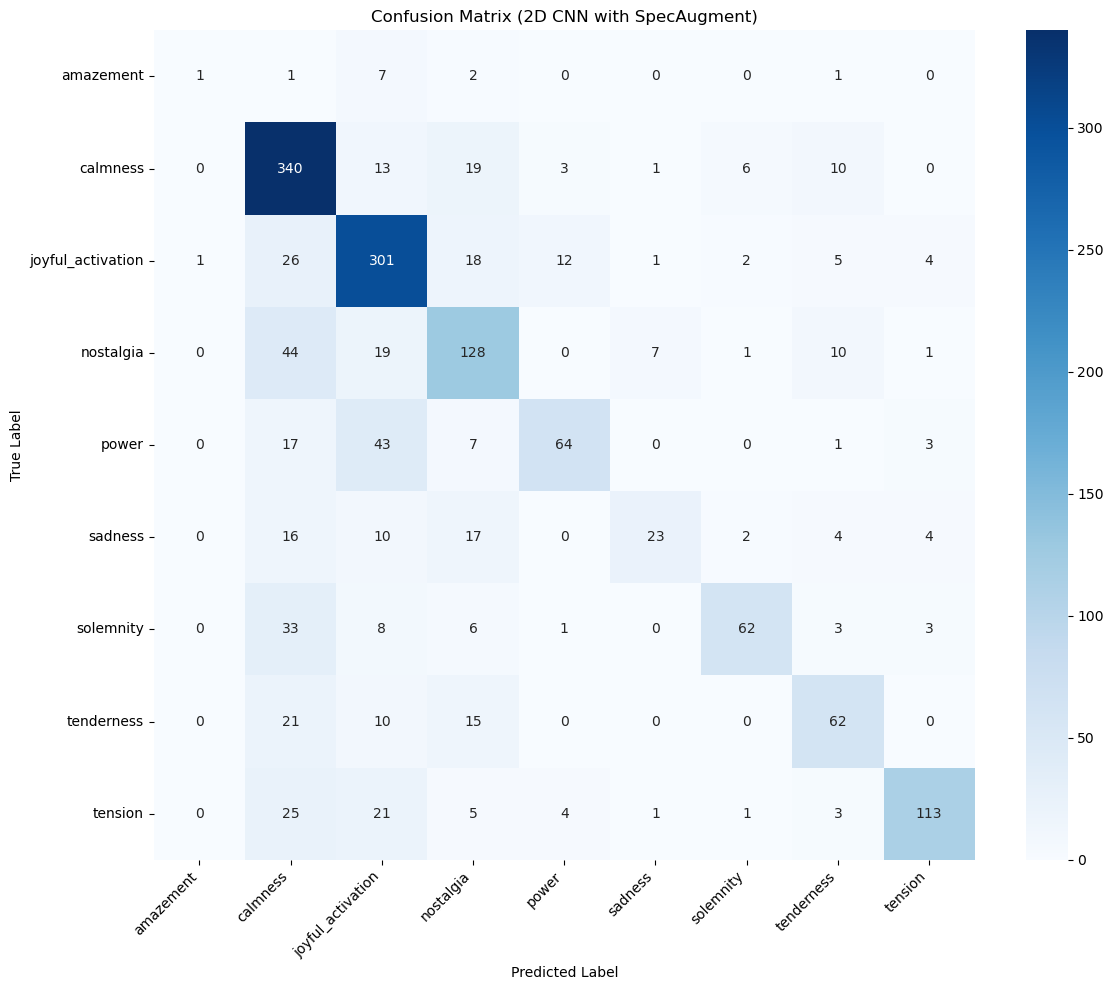

In [7]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Dropout,
    Dense,
    Input,
    Flatten,
    BatchNormalization,
    Layer
)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tqdm import tqdm

# --- Configuration ---
ANNOTATIONS_PATH = "./data.csv"
AUDIO_DIR = "./audio" 
SEGMENT_DURATION = 3  # seconds

# --- Custom Keras Layer for SpecAugment ---
class SpecAugment(Layer):
    """
    Custom Keras layer to perform SpecAugment (frequency and time masking).
    This layer is active only during training.
    """
    def __init__(self, freq_mask_param, time_mask_param, num_freq_masks=1, num_time_masks=1, **kwargs):
        super(SpecAugment, self).__init__(**kwargs)
        self.freq_mask_param = freq_mask_param
        self.time_mask_param = time_mask_param
        self.num_freq_masks = num_freq_masks
        self.num_time_masks = num_time_masks

    def call(self, inputs, training=None):
        if not training:
            return inputs

        augmented_inputs = inputs
        # Get spectrogram shape: (batch, n_mels, n_steps, channels)
        n_mels = tf.shape(inputs)[1]
        n_steps = tf.shape(inputs)[2]

        # Apply frequency masking
        for _ in range(self.num_freq_masks):
            f = tf.random.uniform(shape=(), minval=0, maxval=self.freq_mask_param, dtype=tf.int32)
            f0 = tf.random.uniform(shape=(), minval=0, maxval=n_mels - f, dtype=tf.int32)
            
            # Create a boolean mask and apply it
            freq_band = tf.range(n_mels)
            mask = (freq_band >= f0) & (freq_band < f0 + f)
            mask = tf.reshape(mask, (1, n_mels, 1, 1))
            augmented_inputs = tf.where(mask, 0.0, augmented_inputs)

        # Apply time masking
        for _ in range(self.num_time_masks):
            t = tf.random.uniform(shape=(), minval=0, maxval=self.time_mask_param, dtype=tf.int32)
            t0 = tf.random.uniform(shape=(), minval=0, maxval=n_steps - t, dtype=tf.int32)

            # Create a boolean mask and apply it
            time_step_range = tf.range(n_steps)
            mask = (time_step_range >= t0) & (time_step_range < t0 + t)
            mask = tf.reshape(mask, (1, 1, n_steps, 1))
            augmented_inputs = tf.where(mask, 0.0, augmented_inputs)
            
        return augmented_inputs

    def get_config(self):
        config = super().get_config()
        config.update({
            "freq_mask_param": self.freq_mask_param,
            "time_mask_param": self.time_mask_param,
            "num_freq_masks": self.num_freq_masks,
            "num_time_masks": self.num_time_masks,
        })
        return config

# --- Feature Extraction & Label Prep ---
def extract_spectrogram(file_path, duration=3):
    try:
        audio, sr = librosa.load(file_path, sr=22050, duration=60)
        spectrograms = []
        samples_per_segment = int(duration * sr)

        for start in range(0, len(audio) - samples_per_segment + 1, samples_per_segment):
            segment = audio[start:start + samples_per_segment]
            mel_spect = librosa.feature.melspectrogram(y=segment, sr=sr, n_fft=2048, hop_length=512, n_mels=128, fmax=8000)
            db_spect = librosa.power_to_db(mel_spect, ref=np.max)
            spectrograms.append(db_spect)
            
        return spectrograms
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return []

def load_and_prepare_labels(annotations_path):
    # This function remains the same
    print("Loading and preprocessing labels...")
    df = pd.read_csv(annotations_path)
    emotion_cols = [
        ' amazement', ' solemnity', ' tenderness', ' nostalgia', 
        ' calmness', ' power', ' joyful_activation', ' tension', ' sadness'
    ]
    song_emotion_scores = df.groupby('track id')[emotion_cols].mean()
    song_emotion_scores['dominant_emotion'] = song_emotion_scores[emotion_cols].idxmax(axis=1)
    song_emotion_scores['dominant_emotion'] = song_emotion_scores['dominant_emotion'].str.strip()
    return song_emotion_scores.reset_index()[['track id', 'dominant_emotion']]

# --- Model Building (2D CNN with SpecAugment) ---
def build_augmented_2d_cnn_model(input_shape, num_classes):
    """
    Builds a 2D CNN with a SpecAugment layer for data augmentation.
    """
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    # *** ADD AUGMENTATION LAYER ***
    # Parameters are chosen based on common practices.
    # It will mask up to 20 frequency channels and up to 25 time steps.
    model.add(SpecAugment(freq_mask_param=20, time_mask_param=25, num_freq_masks=2, num_time_masks=2))
    
    # CNN Blocks
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# --- Main Execution ---
if __name__ == '__main__':
    labeled_data = load_and_prepare_labels(ANNOTATIONS_PATH)
    print("Class distribution:\n", labeled_data['dominant_emotion'].value_counts())

    print("\nExtracting Spectrograms...")
    all_features = []
    all_labels = []
    for _, row in tqdm(labeled_data.iterrows(), total=len(labeled_data), desc="Processing Audio"):
        audio_path = os.path.join(AUDIO_DIR, f"{row['track id']}.mp3")
        if os.path.exists(audio_path):
            spectrograms = extract_spectrogram(audio_path, duration=SEGMENT_DURATION)
            if spectrograms:
                all_features.extend(spectrograms)
                all_labels.extend([row['dominant_emotion']] * len(spectrograms))
    
    if not all_features: exit("\nError: No spectrograms were extracted.")

    X = np.array(all_features)
    y_str = np.array(all_labels)

    print("\nEncoding labels and splitting data...")
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y_str)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    print("\nBuilding and training the Augmented 2D CNN model...")
    model = build_augmented_2d_cnn_model(X_train.shape[1:], len(label_encoder.classes_))
    model.summary()
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)

    history = model.fit(
        X_train,
        y_train,
        validation_split=0.2, # Use a portion of training data for validation
        epochs=150,           # Train longer, relying on early stopping
        batch_size=32,
        callbacks=[reduce_lr, early_stop]
    )

    print("\nEvaluating final model on the unseen test set...")
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Final Test Accuracy: {test_accuracy:.4f}")

    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix (2D CNN with SpecAugment)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


Ensembled with bidirectional LSTM-CNN hybrid and CNN using SpecAugmentation

accuracy: 76%

Loading and preprocessing labels...

PART 1: TRAINING BIDIRECTIONAL LSTM MODEL


Extracting 1D Features:  57%|█████▋    | 227/400 [20:08<15:34,  5.40s/it]c:\Users\Elite\anaconda3\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Extracting 1D Features: 100%|██████████| 400/400 [35:39<00:00,  5.35s/it]


Epoch 1/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.3667 - loss: 1.7648 - val_accuracy: 7.0847e-04 - val_loss: 2.6931
Epoch 2/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5360 - loss: 1.2992 - val_accuracy: 0.0177 - val_loss: 2.5598
Epoch 3/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6114 - loss: 1.1029 - val_accuracy: 0.0804 - val_loss: 2.6141
Epoch 4/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6573 - loss: 0.9581 - val_accuracy: 0.2795 - val_loss: 2.0078
Epoch 5/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7152 - loss: 0.8310 - val_accuracy: 0.4240 - val_loss: 1.4863
Epoch 6/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7433 - loss: 0.7516 - val_accuracy: 0.2763 - val_loss: 2.2239
Epoch 7/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7770 - loss: 0.6492 - val_accuracy: 0.4651 - val_loss: 1.5168
Epoch 8/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7976 - loss: 0.606

Extracting Spectrograms: 100%|██████████| 400/400 [01:41<00:00,  3.94it/s]


Epoch 1/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 29s 167ms/step - accuracy: 0.1728 - loss: 3.6190 - val_accuracy: 0.2771 - val_loss: 2.0559
Epoch 2/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 26s 164ms/step - accuracy: 0.2378 - loss: 2.2779 - val_accuracy: 0.3061 - val_loss: 1.9803
Epoch 3/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 26s 164ms/step - accuracy: 0.2627 - loss: 2.1093 - val_accuracy: 0.3320 - val_loss: 1.8921
Epoch 4/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 26s 163ms/step - accuracy: 0.2776 - loss: 2.0340 - val_accuracy: 0.3799 - val_loss: 1.8191
Epoch 5/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 26s 165ms/step - accuracy: 0.3047 - loss: 1.9871 - val_accuracy: 0.3752 - val_loss: 1.7386
Epoch 6/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.3095 - loss: 1.9030 - val_accuracy: 0.3995 - val_loss: 1.7492
Epoch 7/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 111ms/step - accuracy: 0.3248 - loss: 1.9052 - val_accuracy: 0.3893 - val_loss: 1.7217
Epoch 8/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 26s 165ms/step - accuracy: 0.3435 - 

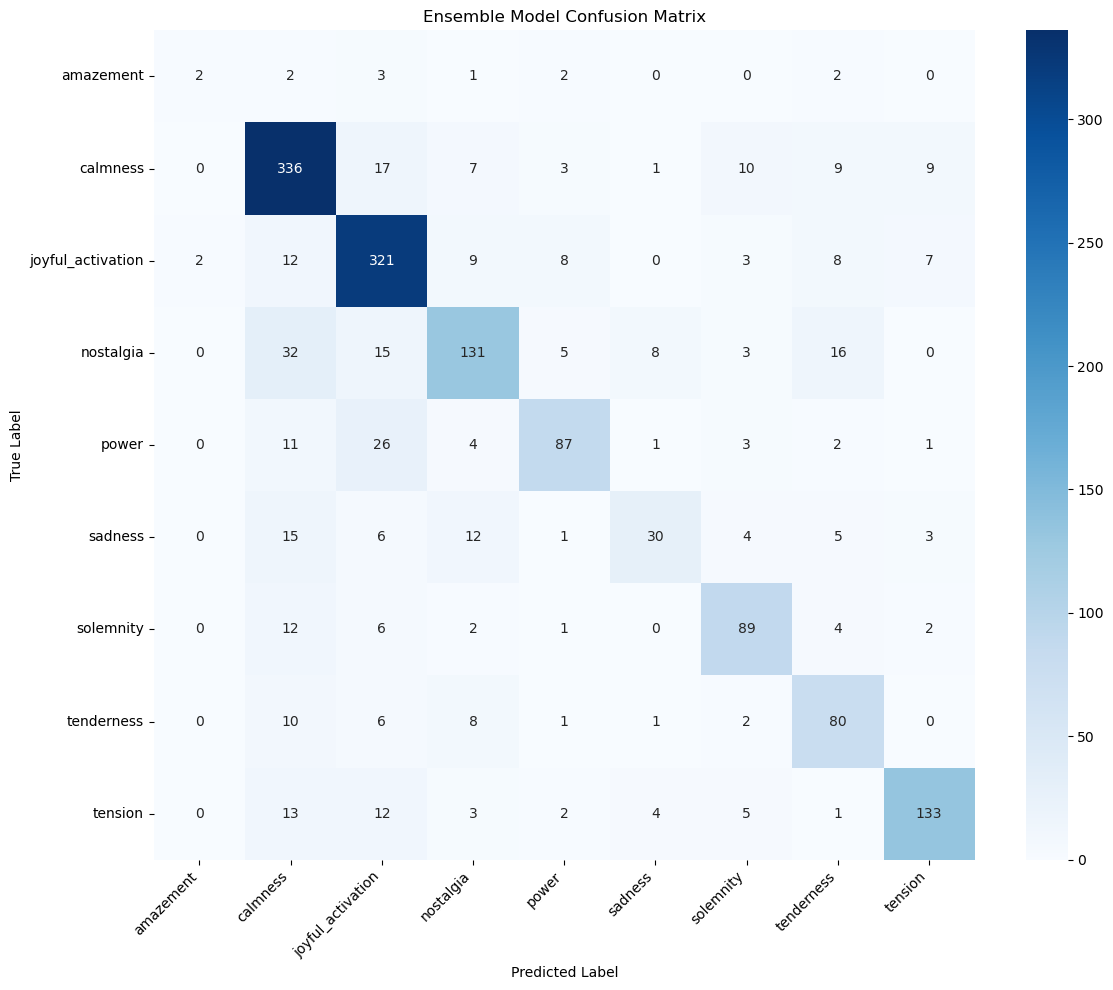

In [9]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import os
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dropout, Dense, Input,
    Flatten, BatchNormalization, LSTM, Bidirectional, Layer
)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tqdm import tqdm

# --- Configuration ---
ANNOTATIONS_PATH = "./data.csv"
AUDIO_DIR = "./audio" 
SEGMENT_DURATION = 3
MODEL_1D_PATH = 'model_1d_bidir_lstm.keras'
MODEL_2D_PATH = 'model_2d_cnn_specaugment.keras'

# ==============================================================================
# SECTION 1: DATA PREPARATION (FOR BOTH MODELS)
# ==============================================================================

def load_and_prepare_labels(annotations_path):
    print("Loading and preprocessing labels...")
    df = pd.read_csv(annotations_path)
    emotion_cols = [' amazement', ' solemnity', ' tenderness', ' nostalgia', ' calmness', ' power', ' joyful_activation', ' tension', ' sadness']
    song_emotion_scores = df.groupby('track id')[emotion_cols].mean()
    song_emotion_scores['dominant_emotion'] = song_emotion_scores[emotion_cols].idxmax(axis=1)
    song_emotion_scores['dominant_emotion'] = song_emotion_scores['dominant_emotion'].str.strip()
    return song_emotion_scores.reset_index()[['track id', 'dominant_emotion']]

# --- Feature Extractor for 1D Model (Bidirectional LSTM) ---
def extract_1d_features(file_path, duration=3):
    try:
        audio, sr = librosa.load(file_path, sr=22050, duration=60)
        features_list = []
        samples_per_segment = int(duration * sr)
        for start in range(0, len(audio) - samples_per_segment + 1, samples_per_segment):
            segment = audio[start:start + samples_per_segment]
            chroma_stft = librosa.feature.chroma_stft(y=segment, sr=sr)
            rms = librosa.feature.rms(y=segment)
            spec_cent = librosa.feature.spectral_centroid(y=segment, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=segment, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=segment, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(segment)
            mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=20)
            spec_contrast = librosa.feature.spectral_contrast(y=segment, sr=sr)
            tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(segment), sr=sr)
            
            base_features = np.hstack([np.mean(chroma_stft), np.std(chroma_stft), np.mean(rms), np.std(rms), np.mean(spec_cent), np.std(spec_cent), np.mean(spec_bw), np.std(spec_bw), np.mean(rolloff), np.std(rolloff), np.mean(zcr), np.std(zcr)])
            mfcc_features = np.hstack([np.mean(e) for e in mfcc] + [np.std(e) for e in mfcc])
            spec_contrast_features = np.hstack([np.mean(e) for e in spec_contrast] + [np.std(e) for e in spec_contrast])
            tonnetz_features = np.hstack([np.mean(e) for e in tonnetz] + [np.std(e) for e in tonnetz])
            all_segment_features = np.hstack([base_features, mfcc_features, spec_contrast_features, tonnetz_features])
            features_list.append(all_segment_features)
        return features_list
    except Exception: return []

# --- Feature Extractor for 2D Model (CNN) ---
def extract_spectrograms(file_path, duration=3):
    try:
        audio, sr = librosa.load(file_path, sr=22050, duration=60)
        spectrograms = []
        samples_per_segment = int(duration * sr)
        for start in range(0, len(audio) - samples_per_segment + 1, samples_per_segment):
            segment = audio[start:start + samples_per_segment]
            mel_spect = librosa.feature.melspectrogram(y=segment, sr=sr, n_fft=2048, hop_length=512, n_mels=128, fmax=8000)
            db_spect = librosa.power_to_db(mel_spect, ref=np.max)
            spectrograms.append(db_spect)
        return spectrograms
    except Exception: return []

# ==============================================================================
# SECTION 2: MODEL ARCHITECTURES
# ==============================================================================

# --- Model 1: Bidirectional LSTM ---
def build_bidir_lstm_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=5, strides=2, padding='same'),
        Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=5, strides=2, padding='same'),
        Dropout(0.3),
        Bidirectional(LSTM(64)),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# --- Model 2: 2D CNN with SpecAugment ---
class SpecAugment(Layer):
    def __init__(self, freq_mask_param=20, time_mask_param=25, num_freq_masks=2, num_time_masks=2, **kwargs):
        super().__init__(**kwargs)
        self.freq_mask_param, self.time_mask_param = freq_mask_param, time_mask_param
        self.num_freq_masks, self.num_time_masks = num_freq_masks, num_time_masks
    def call(self, inputs, training=None):
        if not training: return inputs
        n_mels, n_steps = tf.shape(inputs)[1], tf.shape(inputs)[2]
        augmented = inputs
        for _ in range(self.num_freq_masks):
            f = tf.random.uniform((), 0, self.freq_mask_param, dtype=tf.int32)
            f0 = tf.random.uniform((), 0, n_mels - f, dtype=tf.int32)
            mask = tf.reshape((tf.range(n_mels) >= f0) & (tf.range(n_mels) < f0 + f), (1, n_mels, 1, 1))
            augmented = tf.where(mask, 0.0, augmented)
        for _ in range(self.num_time_masks):
            t = tf.random.uniform((), 0, self.time_mask_param, dtype=tf.int32)
            t0 = tf.random.uniform((), 0, n_steps - t, dtype=tf.int32)
            mask = tf.reshape((tf.range(n_steps) >= t0) & (tf.range(n_steps) < t0 + t), (1, 1, n_steps, 1))
            augmented = tf.where(mask, 0.0, augmented)
        return augmented

def build_augmented_2d_cnn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        SpecAugment(),
        Conv2D(32, (3, 3), activation='relu'), MaxPooling2D((2, 2)), BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'), MaxPooling2D((2, 2)), BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu'), MaxPooling2D((2, 2)), BatchNormalization(),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    # Using AdamW optimizer for better regularization
    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-5), 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ==============================================================================
# SECTION 3: MAIN EXECUTION
# ==============================================================================
if __name__ == '__main__':
    
    # --- Load Labels (common for both models) ---
    labeled_data = load_and_prepare_labels(ANNOTATIONS_PATH)
    label_encoder = LabelEncoder()
    label_encoder.fit(labeled_data['dominant_emotion'])
    num_classes = len(label_encoder.classes_)

    # --- Train and Save Model 1: Bidirectional LSTM ---
    print("\n" + "="*50)
    print("PART 1: TRAINING BIDIRECTIONAL LSTM MODEL")
    print("="*50)
    all_features_1d, all_labels_1d = [], []
    for _, row in tqdm(labeled_data.iterrows(), total=len(labeled_data), desc="Extracting 1D Features"):
        features = extract_1d_features(os.path.join(AUDIO_DIR, f"{row['track id']}.mp3"))
        if features:
            all_features_1d.extend(features)
            all_labels_1d.extend([row['dominant_emotion']] * len(features))
    
    X1d = np.array(all_features_1d)
    y1d_str = np.array(all_labels_1d)
    y1d = label_encoder.transform(y1d_str)

    X1d_train, X1d_test, y1d_train, y1d_test = train_test_split(X1d, y1d, test_size=0.2, random_state=42, stratify=y1d)
    
    smote = SMOTE(random_state=42)
    X1d_train_res, y1d_train_res = smote.fit_resample(X1d_train, y1d_train)
    
    scaler = StandardScaler()
    X1d_train_scaled = scaler.fit_transform(X1d_train_res)
    X1d_test_scaled = scaler.transform(X1d_test)
    
    X1d_train_reshaped = np.expand_dims(X1d_train_scaled, axis=2)
    X1d_test_reshaped = np.expand_dims(X1d_test_scaled, axis=2)

    model_1d = build_bidir_lstm_model(X1d_train_reshaped.shape[1:], num_classes)
    early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
    model_1d.fit(X1d_train_reshaped, y1d_train_res, validation_split=0.2, epochs=150, batch_size=64, callbacks=[early_stop])
    model_1d.save(MODEL_1D_PATH)
    print(f"Bidirectional LSTM model saved to {MODEL_1D_PATH}")


    # --- Train and Save Model 2: 2D CNN ---
    print("\n" + "="*50)
    print("PART 2: TRAINING 2D CNN MODEL")
    print("="*50)
    all_features_2d, all_labels_2d = [], []
    for _, row in tqdm(labeled_data.iterrows(), total=len(labeled_data), desc="Extracting Spectrograms"):
        features = extract_spectrograms(os.path.join(AUDIO_DIR, f"{row['track id']}.mp3"))
        if features:
            all_features_2d.extend(features)
            all_labels_2d.extend([row['dominant_emotion']] * len(features))

    X2d = np.array(all_features_2d)
    y2d_str = np.array(all_labels_2d)
    y2d = label_encoder.transform(y2d_str)
    
    X2d_train, X2d_test, y2d_train, y2d_test = train_test_split(X2d, y2d, test_size=0.2, random_state=42, stratify=y2d)

    X2d_train_reshaped = X2d_train[..., np.newaxis]
    X2d_test_reshaped = X2d_test[..., np.newaxis]

    model_2d = build_augmented_2d_cnn_model(X2d_train_reshaped.shape[1:], num_classes)
    early_stop_2d = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
    model_2d.fit(X2d_train_reshaped, y2d_train, validation_split=0.2, epochs=150, batch_size=32, callbacks=[early_stop_2d])
    model_2d.save(MODEL_2D_PATH)
    print(f"2D CNN model saved to {MODEL_2D_PATH}")


    # --- Part 3: Ensemble Evaluation ---
    print("\n" + "="*50)
    print("PART 3: ENSEMBLE EVALUATION")
    print("="*50)

    # Load models
    model_1d = load_model(MODEL_1D_PATH)
    # The custom layer must be passed to load_model
    model_2d = load_model(MODEL_2D_PATH, custom_objects={'SpecAugment': SpecAugment})

    # Get predictions from both models on their respective test sets
    pred_1d = model_1d.predict(X1d_test_reshaped)
    pred_2d = model_2d.predict(X2d_test_reshaped)

    # Average the predictions (ensemble)
    # Note: We are assuming the test sets from both pipelines correspond to the same original audio segments
    # due to the fixed random_state in train_test_split.
    ensemble_preds = (pred_1d + pred_2d) / 2.0
    ensemble_y_pred = np.argmax(ensemble_preds, axis=1)

    # Use the labels from one of the test sets (they are the same)
    y_true = y1d_test

    print("\n--- ENSEMBLE CLASSIFICATION REPORT ---")
    print(classification_report(y_true, ensemble_y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_true, ensemble_y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Ensemble Model Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

